In [37]:
import nltk
import re
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline

from gensim.models import FastText
from scipy.cluster.hierarchy import ward, dendrogram
from sklearn.metrics.pairwise import cosine_similarity

nltk.download('stopwords')
nltk.download('punkt')

[nltk_data] Downloading package stopwords to
[nltk_data]     /Users/mgrapotte/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to /Users/mgrapotte/nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [21]:
deck = pd.read_csv("parser_output/Juri_example_output_from_parser.csv")

In [52]:
deck_without_land = deck[deck["type"]!="['Land']"]

In [8]:
stop_words = nltk.corpus.stopwords.words('english')

In [17]:
def normalize_document(doc):
    # lower case and remove special characters\whitespaces
    doc = re.sub(r'[^a-zA-Z0-9\s-]', '', doc, re.I|re.A)
    doc = doc.lower()
    doc = doc.strip()
    # tokenize document
    tokens = nltk.word_tokenize(doc)
    #filter stopwords out of document
    filtered_tokens = [token for token in tokens if token not in stop_words]
    # re-create document from filtered tokens
    doc = ' '.join(filtered_tokens)
    return doc

In [53]:
normalize_corpus = np.vectorize(normalize_document)

norm_corpus = normalize_corpus(list(deck_without_land['text']))
len(norm_corpus)

66

In [73]:
tokenized_docs = [doc.split() for doc in norm_corpus]
ft_model = FastText(tokenized_docs, window=100, min_count=1, workers=4, sg=1)

In [74]:
def averaged_word2vec_vectorizer(corpus, model, num_features):
    vocabulary = set(model.wv.index_to_key)
    
    def average_word_vectors(words, model, vocabulary, num_features):
        feature_vector = np.zeros((num_features,), dtype="float64")
        nwords = 0.
        
        for word in words:
            if word in vocabulary: 
                nwords = nwords + 1.
                feature_vector = np.add(feature_vector, model.wv[word])
        if nwords:
            feature_vector = np.divide(feature_vector, nwords)

        return feature_vector

    features = [average_word_vectors(tokenized_sentence, model, vocabulary, num_features)
                    for tokenized_sentence in corpus]
    return np.array(features)

In [75]:
doc_vecs_ft = averaged_word2vec_vectorizer(tokenized_docs, ft_model, 100)
doc_vecs_ft.shape

(66, 100)

In [76]:
def ward_hierarchical_clustering(feature_matrix):
    
    cosine_distance = 1 - cosine_similarity(feature_matrix)
    linkage_matrix = ward(cosine_distance)
    return linkage_matrix

In [77]:
def plot_hierarchical_clusters(linkage_matrix, deck_data, p=100, figure_size=(8,12)):
    # set size
    fig, ax = plt.subplots(figsize=figure_size) 
    card_names = deck_data['name'].values.tolist()
    # plot dendrogram
    R = dendrogram(linkage_matrix, orientation="left", labels=card_names,
                    truncate_mode='lastp', 
                    p=p,  
                    no_plot=True)
    temp = {R["leaves"][ii]: card_names[ii] for ii in range(len(R["leaves"]))}
    def llf(xx):
        return "{}".format(temp[xx])
    ax = dendrogram(
            linkage_matrix,
            truncate_mode='lastp',
            orientation="left",
            p=p,  
            leaf_label_func=llf, 
            leaf_font_size=10.,
            )
    plt.tick_params(axis= 'x',   
                    which='both',  
                    bottom='off',
                    top='off',
                    labelbottom='off')
    plt.tight_layout()

In [78]:
linkage_matrix = ward_hierarchical_clustering(doc_vecs_ft)

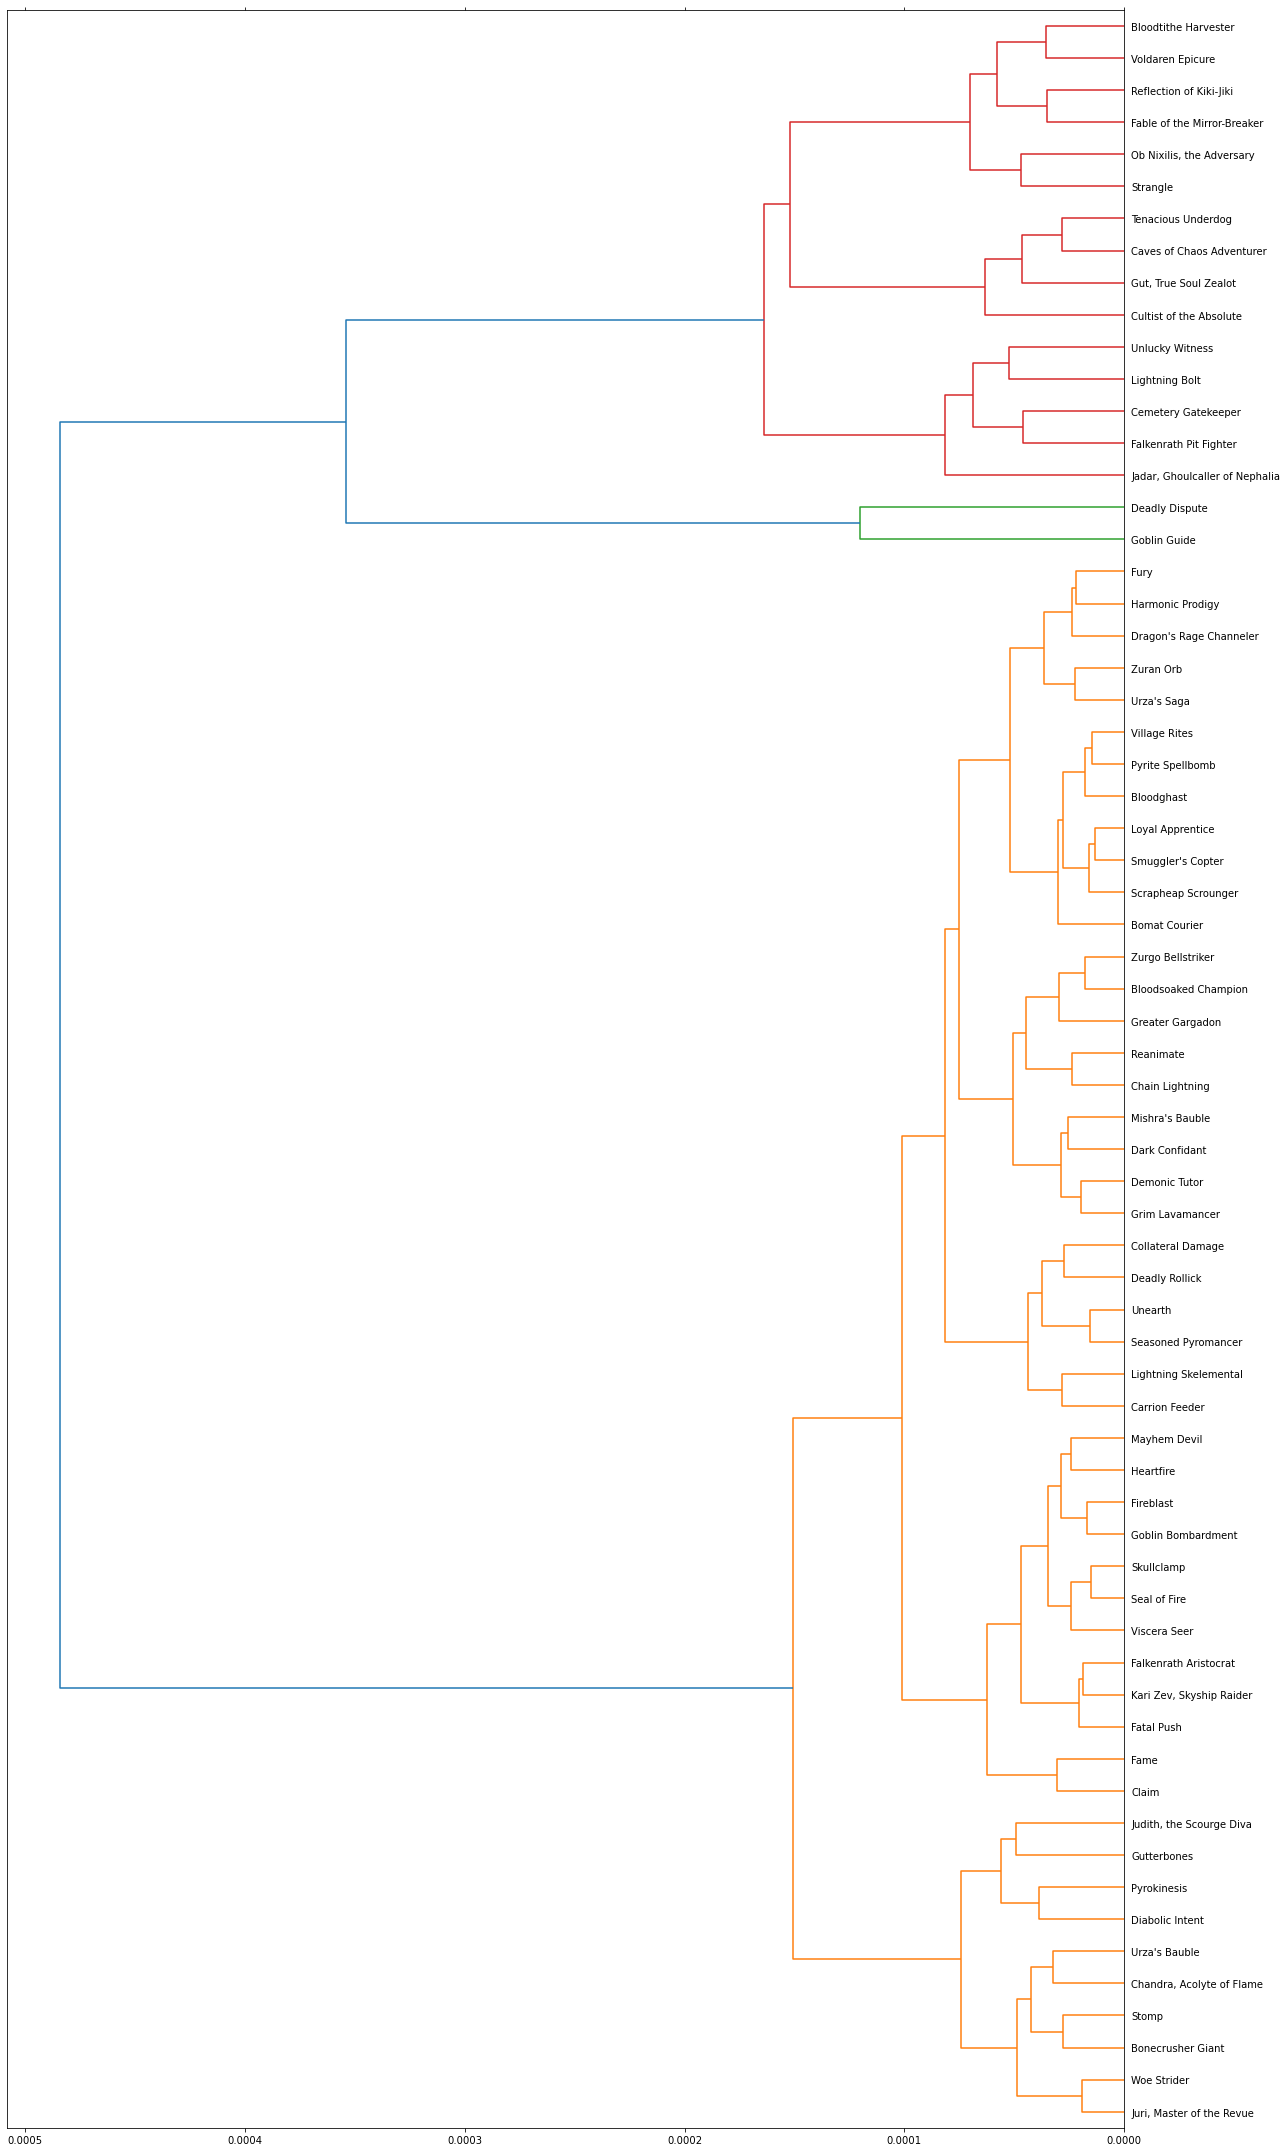

In [79]:
plot_hierarchical_clusters(linkage_matrix,
                           p=200,
                           deck_data=deck_without_land,
                           figure_size=(18, 30))

### LDA 

In [97]:
from wordcloud import WordCloud
from gensim.utils import simple_preprocess
import gensim.corpora as corpora

import gensim

In [133]:
stop_words.extend(['creature','card','cards','may'])

In [134]:
wordcloud = WordCloud(background_color="white", max_words=5000, contour_width=3, contour_color='steelblue')

In [135]:
long_string = ','.join(norm_corpus)

In [136]:
wordcloud.generate(long_string)

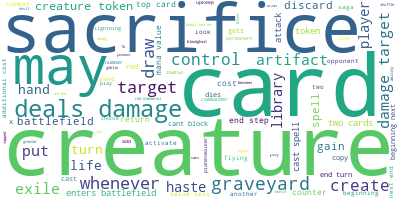

In [137]:
wordcloud.to_image()

In [138]:
def sent_to_words(sentences):
    for sentence in sentences:
        # deacc=True removes punctuations
        yield(gensim.utils.simple_preprocess(str(sentence), deacc=True))
        
def remove_stopwords(texts):
    return [[word for word in simple_preprocess(str(doc)) if word not in stop_words] for doc in texts]

In [139]:
data = deck_without_land.text.values.tolist()
data_words = list(sent_to_words(data))# remove stop words
data_words = remove_stopwords(data_words)

In [140]:
# Create Dictionary
id2word = corpora.Dictionary(data_words)# Create Corpus
texts = data_words# Term Document Frequency
corpus = [id2word.doc2bow(text) for text in texts]# View
print(corpus[:1][0][:30])

[(0, 1), (1, 1), (2, 1), (3, 1), (4, 1), (5, 2), (6, 1), (7, 1), (8, 1), (9, 1), (10, 1), (11, 1), (12, 1), (13, 1)]


In [160]:
from pprint import pprint# number of topics
num_topics = 3# Build LDA model
lda_model = gensim.models.LdaMulticore(corpus=corpus,
                                       id2word=id2word,
                                       num_topics=num_topics)# Print the Keyword in the 10 topics
pprint(lda_model.print_topics())
doc_lda = lda_model[corpus]

[(0,
  '0.026*"battlefield" + 0.025*"sacrifice" + 0.024*"draw" + 0.020*"token" + '
  '0.018*"discard" + 0.018*"create" + 0.018*"whenever" + 0.017*"library" + '
  '0.015*"enters" + 0.015*"target"'),
 (1,
  '0.025*"sacrifice" + 0.025*"target" + 0.024*"spell" + 0.023*"cast" + '
  '0.023*"graveyard" + 0.020*"exile" + 0.020*"cost" + 0.018*"battlefield" + '
  '0.016*"mana" + 0.016*"two"'),
 (2,
  '0.034*"target" + 0.033*"damage" + 0.032*"sacrifice" + 0.029*"deals" + '
  '0.020*"player" + 0.018*"spell" + 0.017*"whenever" + 0.017*"turn" + '
  '0.016*"end" + 0.014*"beginning"')]


In [161]:
import pyLDAvis.gensim_models as gensimvis
import pickle 
import pyLDAvis# Visualize the topics
import os
pyLDAvis.enable_notebook()


LDAvis_prepared = gensimvis.prepare(lda_model, corpus, id2word)


/Users/mgrapotte/opt/anaconda3/envs/mtg/lib/python3.9/site-packages/pyLDAvis/_prepare.py:246: FutureWarning: In a future version of pandas all arguments of DataFrame.drop except for the argument 'labels' will be keyword-only.
  default_term_info = default_term_info.sort_values(
/Users/mgrapotte/opt/anaconda3/envs/mtg/lib/python3.9/site-packages/past/builtins/misc.py:45: DeprecationWarning: the imp module is deprecated in favour of importlib; see the module's documentation for alternative uses
  from imp import reload


In [162]:
LDAvis_prepared

PreparedData(topic_coordinates=              x         y  topics  cluster       Freq
topic                                                
1      0.005341 -0.051478       1        1  37.914347
2     -0.051602  0.021525       2        1  35.648144
0      0.046261  0.029953       3        1  26.437508, topic_info=            Term       Freq      Total Category  logprob  loglift
139      discard   7.000000   7.000000  Default  30.0000  30.0000
61          draw  12.000000  12.000000  Default  29.0000  29.0000
64        player   9.000000   9.000000  Default  28.0000  28.0000
15   battlefield  16.000000  16.000000  Default  27.0000  27.0000
1         damage  18.000000  18.000000  Default  26.0000  26.0000
..           ...        ...        ...      ...      ...      ...
12        target   3.925874  25.097380   Topic3  -4.1997  -0.5248
23         exile   2.954196  12.809949   Topic3  -4.4841  -0.1366
40          turn   2.311220  14.195123   Topic3  -4.7295  -0.4847
46         haste   2.193265  10.245484   Topic3  -4.7819  -0.2111
2          deals   2.202742  17.116261   Topic3  -4.7776  -0.7199

[216 rows x 6 columns], token_table=      Topic      Freq        Term
term                             
213       1  0.613385     ability
213       2  0.306693     ability
80        2  0.447182    activate
80        3  0.447182    activate
68        1  0.701711  additional
...     ...       ...         ...
242       2  0.650235     witness
217       1  0.614405      wizard
32        1  0.812037         woe
111       3  0.667495         zev
231       2  0.650311      zombie

[253 rows x 3 columns], R=30, lambda_step=0.01, plot_opts={'xlab': 'PC1', 'ylab': 'PC2'}, topic_order=[2, 3, 1])